# NicheCompass Query Reference Mapping Tutorial

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 18.05.2023
- **Date of Last Modification:** 09.06.2023

- In this tutorial, we will use two batches of a STARmap PLUS mouse brain dataset from Shi, H. et al. Spatial Atlas of the Mouse Central Nervous System at Molecular Resolution. bioRxiv 2022.06.20.496914 (2022) to train a reference model, and one batch of the same dataset as query that we will map onto the reference.
- Check the repository [README.md](https://github.com/sebastianbirk/nichecompass#installation) for NicheCompass installation -instructions.
- The data for this tutorial can be downloaded from [OneDrive](https://1drv.ms/f/s!Atya0VClQocLgvRFj0hYrFICVi0C2w?e=2uLfVX). It has to be stored under ```<repository_root>/data/spatial_omics/```.
    - starmap_plus_mouse_cns_batch1.h5ad
    - starmap_plus_mouse_cns_batch2.h5ad
    - starmap_plus_mouse_cns_batch3.h5ad
- A pretrained model can be downloaded from [OneDrive](https://1drv.ms/f/s!Atya0VClQocLgvRFj0hYrFICVi0C2w?e=2uLfVX). It has to be stored under ```<repository_root>/artifacts/oneshot_sample_integration/models/```.
    - xx

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import os
import warnings
from datetime import datetime

import anndata as ad
import numpy as np
import scanpy as sc
import scipy.sparse as sp
import squidpy as sq

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                aggregate_obsp_matrix_per_cell_type,
                                create_cell_type_chord_plot_from_df,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_ligand_target_mx,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                generate_enriched_gp_info_plots,
                                get_unique_genes_from_gp_dict)

from color_utils import (latent_cluster_colors,
                         starmap_plus_mouse_cns_cell_type_colors as cell_type_colors)

### 1.2 Define Parameters

In [3]:
### Dataset ###
dataset = "starmap_plus_mouse_cns"
reference_batches = ["batch1", "batch2"]
query_batches = ["batch3"]
spatial_key = "spatial"
n_neighbors = 12
filter_genes = True
n_hvg = 3000

### Model ###
# AnnData keys
counts_key = "counts"
adj_key = "spatial_connectivities"
condition_key = "batch"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_sources_mask_key = "nichecompass_gp_sources"
latent_key = "nichecompass_latent"

# Architecture
active_gp_thresh_ratio = 0.1
node_label_method = "one-hop-norm" # choose one-hop-attention for more performant model training
log_variational = counts_key == "counts" # True if raw counts, False if log normalized counts

# Trainer
n_epochs = 100
n_epochs_all_gps = 25
n_epochs_no_cond_contrastive = 5
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_cond_contrastive = 0.
contrastive_logits_ratio = 0.
lambda_l1_masked = 10.
edge_batch_size = 512 # 2048
use_cuda_if_available = True

### Analysis ###
cell_type_key = "Main_molecular_cell_type"
random_seed = 0

### 1.3 Run Notebook Setup

In [4]:
warnings.filterwarnings("ignore")

In [5]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths

In [6]:
# Define paths
gp_data_folder_path = "../data/gene_programs"
so_data_folder_path = "../data/spatial_omics"
omnipath_ligand_receptor_interactions_file_path = f"{gp_data_folder_path}/omnipath_lr_interactions.csv"
nichenet_ligand_target_interactions_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
artifacts_folder_path = f"../artifacts"
figure_folder_path = f"{artifacts_folder_path}/figures"
model_folder_path = f"{artifacts_folder_path}/models"

## 2. Reference Model Preparation

### 2.1 Create Prior Knowledge Cell-Cell-Interaction (CCI) Gene Program (GP) Mask

- NicheCompass expects a prior CCI GP mask as input, which it will use to make its latent embedding interpretable (through a linear masked decoder). 
- The user can provide a custom GP mask to NicheCompass based on the dataset, application, and hypothesis of interest.
- As a default, we create a GP mask based on three databases of prior CCI knowledge:
    - OmniPath
    - NicheNet
    - MEBOCOST

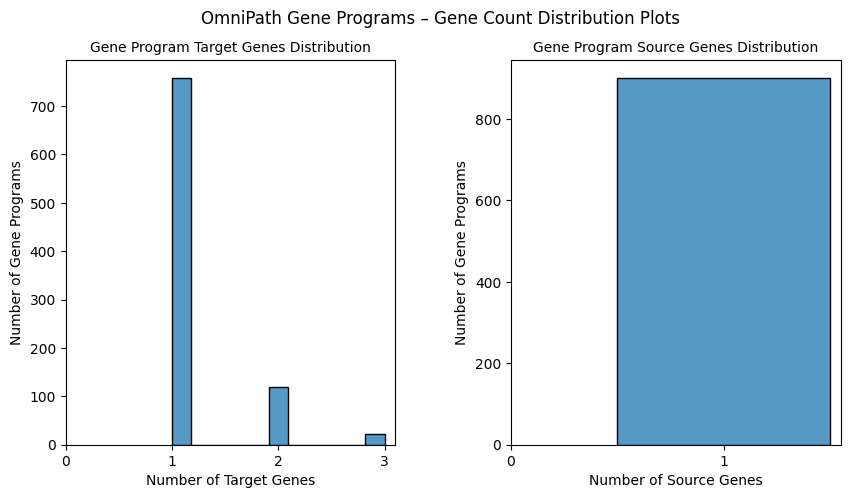

In [7]:
# Retrieve OmniPath GPs (source: ligand gene; target: receptor gene)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_ligand_receptor_interactions_file_path,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source and target genes from OmniPath GPs to keep
# those genes when filtering
omnipath_genes = get_unique_genes_from_gp_dict(
    gp_dict=omnipath_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

In [8]:
# Display example OmniPath GPs
for i, (key, value) in enumerate(omnipath_gp_dict.items()):
    if i > 4:
        break
    print(key, value)

BDNF_ligand_receptor_GP {'sources': ['BDNF'], 'targets': ['DRD4']}
EPOR_ligand_receptor_GP {'sources': ['EPOR'], 'targets': ['STAT3']}
FYN_ligand_receptor_GP {'sources': ['FYN'], 'targets': ['MAPK7']}
AVP_ligand_receptor_GP {'sources': ['AVP'], 'targets': ['AQP2']}
NGF_ligand_receptor_GP {'sources': ['NGF'], 'targets': ['SMPD2']}


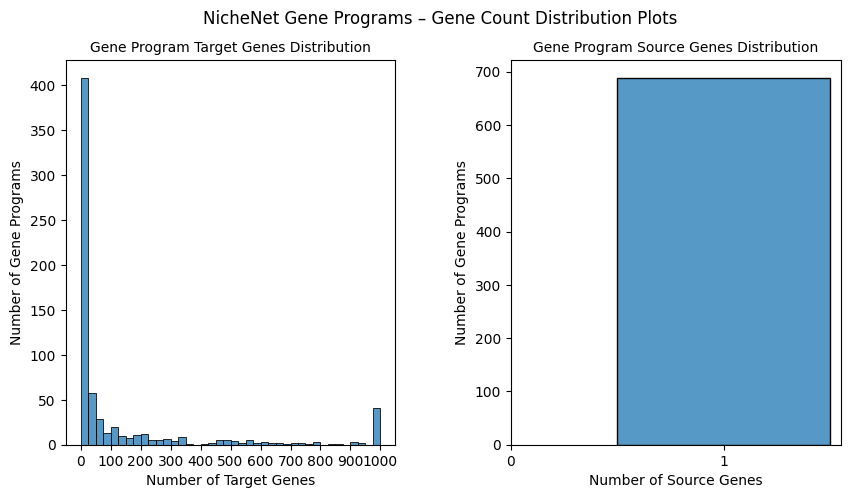

In [ ]:
# Retrieve NicheNet GPs (source: ligand gene; target: target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_genes_ratio=0.01,
    max_n_target_genes_per_gp=1000,
    load_from_disk=False,
    save_to_disk=True,
    file_path=nichenet_ligand_target_interactions_file_path,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source genes from NicheNet GPs to keep
# those genes when filtering
nichenet_source_genes = get_unique_genes_from_gp_dict(
    gp_dict=nichenet_gp_dict,
    retrieved_gene_entities=["sources"])

In [ ]:
# Display example NicheNet GPs
for i, (key, value) in enumerate(nichenet_gp_dict.items()):
    if i > 4:
        break
    print(key, value)

CXCL1_ligand_targetgenes_GP {'sources': ['CXCL1'], 'targets': ['COL1A1', 'HMOX1']}
CXCL2_ligand_targetgenes_GP {'sources': ['CXCL2'], 'targets': ['GRK2', 'GRK5', 'TIMP3']}
CXCL3_ligand_targetgenes_GP {'sources': ['CXCL3'], 'targets': ['VEGFA']}
CXCL5_ligand_targetgenes_GP {'sources': ['CXCL5'], 'targets': []}
PPBP_ligand_targetgenes_GP {'sources': ['PPBP'], 'targets': ['VEGFC', 'VEGFD']}


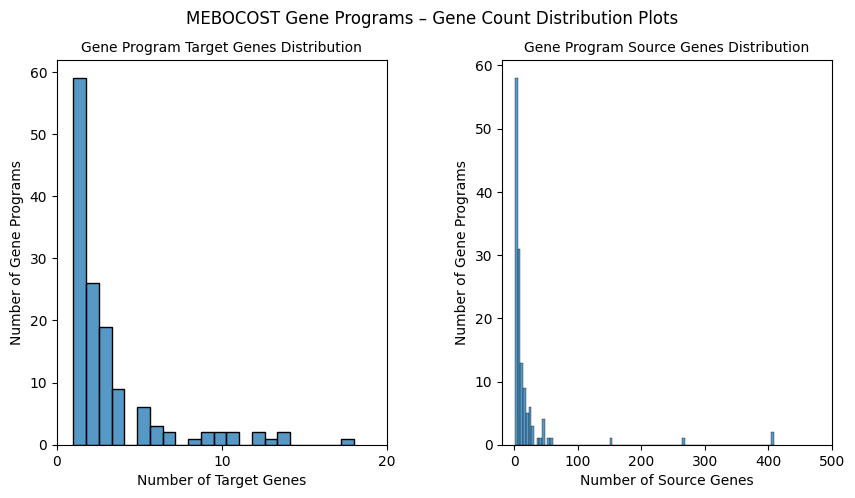

In [ ]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species="mouse",
    plot_gp_gene_count_distributions=True)

# Retrieve unique source and target genes from MEBOCOST GPs to keep
# those genes when filtering
mebocost_genes = get_unique_genes_from_gp_dict(
    gp_dict=mebocost_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

In [ ]:
# Display example MEBOCOST GPs
for i, (key, value) in enumerate(mebocost_gp_dict.items()):
    if i > 4:
        break
    print(key, value)

Deoxyuridine_metabolite_enzyme_sensor_GP {'sources': ['Cda', 'Pnp', 'Pnp2', 'Tk1', 'Tk2', 'Tymp'], 'targets': ['Slc29a2']}
Deoxycytidine_metabolite_enzyme_sensor_GP {'sources': ['Cda', 'Dck', 'Nt5c', 'Nt5c1a', 'Nt5c1b', 'Nt5c2', 'Nt5e', 'Nt5m'], 'targets': ['Slc29a2']}
3-Methoxytyramine_metabolite_enzyme_sensor_GP {'sources': ['Comt', 'Maoa', 'Maob'], 'targets': ['Taar1']}
Biotin_metabolite_enzyme_sensor_GP {'sources': ['Btd', 'Hlcs'], 'targets': ['Slc5a6']}
Androsterone_metabolite_enzyme_sensor_GP {'sources': ['Akr1c12', 'Akr1c13', 'Akr1c14', 'Akr1c18', 'Akr1c19', 'Akr1c20', 'Akr1c21', 'Akr1c6', 'Akr1cl', 'Ugt1a1', 'Ugt1a10', 'Ugt1a2', 'Ugt1a5', 'Ugt1a6b', 'Ugt1a7c', 'Ugt1a9', 'Ugt2a1', 'Ugt2a3', 'Ugt2b1', 'Ugt2b34', 'Ugt2b35', 'Ugt2b36', 'Ugt2b37', 'Ugt2b38', 'Ugt2b5'], 'targets': ['Ar']}


In [ ]:
# Add GPs into one combined dictionary
# for model training
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [14]:
# Filter and combine GPs to avoid overlaps
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Number of gene programs before filtering and combining: 1725.
Number of gene programs after filtering and combining: 1583.


### 2.2 Load Reference Data & Compute Spatial Neighbor Graph

- NicheCompass expects a precomputed spatial adjacency matrix stored in 'adata.obsp[adj_key]'.
- The user can customize the spatial neighbor graph construction based on the dataset, application, and hypothesis of interest.
- In the query reference mapping setting, we will compute a separate spatial adjacency matrix for each sample in the reference and query respectively, and combine them as two disconnected components, one for the reference and one for the query.

In [15]:
adata_batch_list = []
print("Processing reference batches...")
for batch in reference_batches:
    print(f"Processing batch {batch}...")
    print("Loading data...")
    adata_batch = sc.read_h5ad(
        f"{so_data_folder_path}/{dataset}_{batch}.h5ad")

    print("Computing spatial neighborhood graph...\n")
    # Compute (separate) spatial neighborhood graphs
    sq.gr.spatial_neighbors(adata_batch,
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    
    # Make adjacency matrix symmetric
    adata_batch.obsp[adj_key] = (
        adata_batch.obsp[adj_key].maximum(
            adata_batch.obsp[adj_key].T))
    adata_batch_list.append(adata_batch)
adata_reference = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
batch_connectivities = []
len_before_batch = 0
for i in range(len(adata_batch_list)):
    if i == 0: # first batch
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[0].shape[0],
            (adata_reference.shape[0] -
            adata_batch_list[0].shape[0])))
        batch_connectivities.append(sp.hstack(
            (adata_batch_list[0].obsp[adj_key],
            after_batch_connectivities_extension)))
    elif i == (len(adata_batch_list) - 1): # last batch
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
            (adata_reference.shape[0] -
            adata_batch_list[i].shape[0])))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
            adata_batch_list[i].obsp[adj_key])))
    else: # middle batches
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0], len_before_batch))
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
            (adata_reference.shape[0] -
            adata_batch_list[i].shape[0] -
            len_before_batch)))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
            adata_batch_list[i].obsp[adj_key],
            after_batch_connectivities_extension)))
    len_before_batch += adata_batch_list[i].shape[0]
adata_reference.obsp[adj_key] = sp.vstack(batch_connectivities)

Processing batch batch1...
Loading data...
Computing spatial neighborhood graph...

Processing batch batch2...
Loading data...
Computing spatial neighborhood graph...

Processing batch batch3...
Loading data...
Computing spatial neighborhood graph...



### 2.3 Filter Genes

In [16]:
if filter_genes:
    print("Filtering genes...")
    # Filter genes and only keep ligand, receptor, metabolitye enzyme, 
    # metabolite sensor and the 'n_hvg' highly variable genes (potential target
    # genes of nichenet)
    gp_dict_genes = get_unique_genes_from_gp_dict(
        gp_dict=combined_new_gp_dict,
            retrieved_gene_entities=["sources", "targets"])
    print(f"Starting with {len(adata.var_names)} genes.")
    sc.pp.filter_genes(adata,
                       min_cells=0)
    print(f"Keeping {len(adata.var_names)} genes after filtering genes with "
          "expression in 0 cells.")

    if (adata.layers[counts_key].astype(int).astype(np.float32).sum() == 
    adata.layers[counts_key].sum()): # raw counts
        hvg_flavor = "seurat_v3"
    else: # log normalized counts
        hvg_flavor = "seurat"

    sc.pp.highly_variable_genes(
        adata,
        layer=counts_key,
        n_top_genes=n_hvg,
        flavor=hvg_flavor,
        batch_key=condition_key,
        subset=False)

    # Get gene program relevant genes
    gp_relevant_genes = list(set(omnipath_genes + 
                                 nichenet_source_genes + 
                                 mebocost_genes))
    
    adata.var["gp_relevant"] = (
        adata.var.index.str.upper().isin(gp_relevant_genes))
    adata.var["keep_gene"] = (adata.var["gp_relevant"] | 
                              adata.var["highly_variable"])
    adata = adata[:, adata.var["keep_gene"] == True]
    print(f"Keeping {len(adata.var_names)} highly variable or gene program "
          "relevant genes.")
    adata = (adata[:, adata.var_names[adata.var_names.str.upper().isin(
                gp_dict_genes)].sort_values()])
    print(f"Keeping {len(adata.var_names)} genes after filtering genes not in "
          "gp dict.")

Filtering genes...
Starting with 1022 genes.
Keeping 1022 genes after filtering genes with expression in 0 cells.
Keeping 1022 highly variable or gene program relevant genes.
Keeping 872 genes after filtering genes not in gp dict.


In [ ]:
genes = reference_model.adata.var_names

In [ ]:
print("\nFiltering for genes used in reference...")
adata_query = adata_query[:, genes]

### 2.4 Add GP Mask to Data

In [17]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

### 2.5 Explore Data

Summary of batch batch1:
Number of nodes (observations): 91246
Number of node features (genes): 872


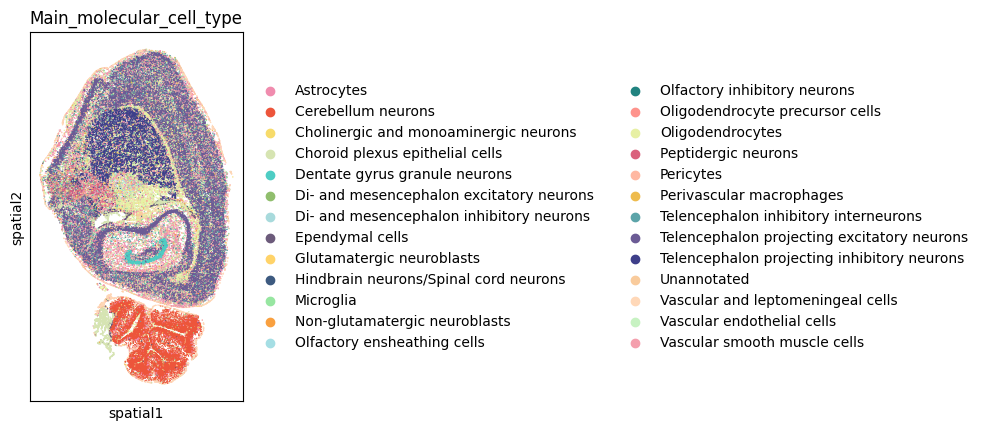

Summary of batch batch2:
Number of nodes (observations): 123836
Number of node features (genes): 872


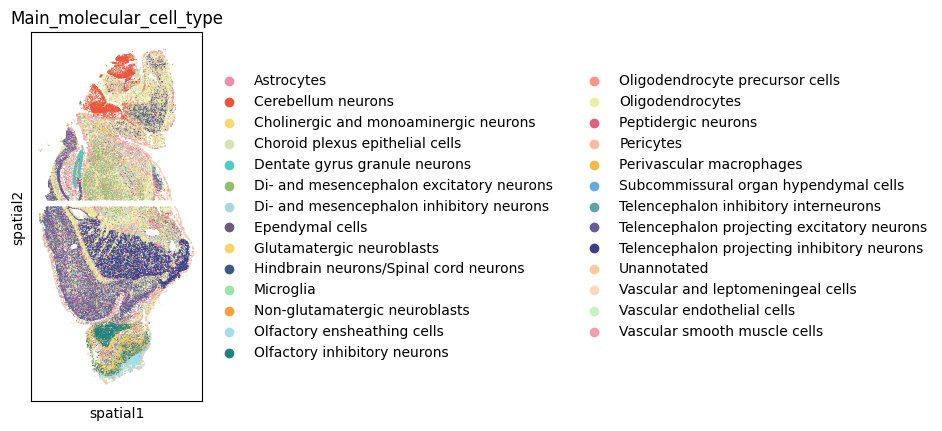

Summary of batch batch3:
Number of nodes (observations): 207591
Number of node features (genes): 872


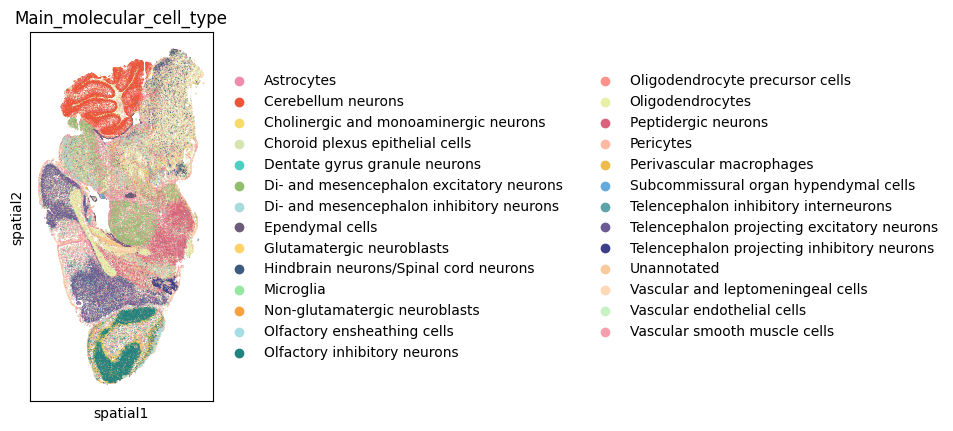

In [20]:
for batch_idx in range(1, len(batches) + 1):
    adata_batch = adata[adata.obs[condition_key] == f"sagittal{batch_idx}"]
    
    print(f"Summary of batch batch{batch_idx}:")
    print(f"Number of nodes (observations): {adata_batch.layers[counts_key].shape[0]}")
    print(f"Number of node features (genes): {adata_batch.layers[counts_key].shape[1]}")

    # Visualize cell-level annotated data in physical space
    sc.pl.spatial(adata_batch,
                  color=cell_type_key,
                  palette=cell_type_colors,
                  spot_size=0.2)        

## 3. Model Training

In [29]:
2 / 0

ZeroDivisionError: division by zero

In [30]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

2586

In [31]:
edge_batch_size = 128 # 2048
use_cuda_if_available = True

### 3.1 Initialize, Train & Save Model

In [32]:
# Initialize model
model = NicheCompass(
    adata,
    counts_key=counts_key,
    adj_key=adj_key,
    condition_key=condition_key,
    gp_names_key=gp_names_key,
    active_gp_names_key=active_gp_names_key,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    latent_key=latent_key,
    active_gp_thresh_ratio=active_gp_thresh_ratio,
    log_variational=log_variational,
    node_label_method=node_label_method)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.1
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['gene_expr_decoder', 'chrom_access_decoder']
ENCODER -> n_input: 872, n_cond_embed_input: 0, n_layers: 1, n_hidden: 678, n_latent: 678, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> n_cond_embed_input: 0, n_cond_embed_output: 678, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 678, n_cond_embed_input: 678, n_addon_input: 0, n_output: 1744
ONE HOP GCN NORM NODE LABEL AGGREGATOR


In [33]:
# Train model
model.train(
    n_epochs=n_epochs,
    n_epochs_all_gps=n_epochs_all_gps,
    n_epochs_no_cond_contrastive=n_epochs_no_cond_contrastive,
    lr=lr,
    lambda_edge_recon=lambda_edge_recon,
    lambda_gene_expr_recon=lambda_gene_expr_recon,
    lambda_cond_contrastive=lambda_cond_contrastive,
    contrastive_logits_ratio=contrastive_logits_ratio,
    lambda_l1_masked=lambda_l1_masked,
    edge_batch_size=edge_batch_size,
    use_cuda_if_available=use_cuda_if_available)


--- INITIALIZING TRAINER ---
Number of training nodes: 380406
Number of validation nodes: 42267
Number of training edges: 2977661
Number of validation edges: 330851
Edge batch size: 128
Node batch size: None

--- MODEL TRAINING ---


KeyboardInterrupt: 

In [ ]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)


# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [ ]:
# Save trained model
os.makedirs(f"{model_folder_path}/{current_timestamp}", exist_ok=True)

model.save(dir_path=f"{model_folder_path}/{current_timestamp}/reference",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

## 4. Query Mapping Preparation

### 4.1 Load Query Data & Compute Spatial Neighbor Graph

Now we load the query samples to finetune the reference model.

In [ ]:
adata_batch_list = []
print("Processing query batches...")
for batch in query_batches:
    print(f"Processing batch {batch}...")
    print("Loading data...")
    adata_batch = sc.read_h5ad(
        f"{so_data_folder_path}/{dataset}_{batch}.h5ad")

    print("Computing spatial neighborhood graph...\n")
    # Compute (separate) spatial neighborhood graphs
    sq.gr.spatial_neighbors(adata_batch,
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    
    # Make adjacency matrix symmetric
    adata_batch.obsp[adj_key] = (
        adata_batch.obsp[adj_key].maximum(
            adata_batch.obsp[adj_key].T))
    adata_batch_list.append(adata_batch)
adata_query = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
batch_connectivities = []
len_before_batch = 0
for i in range(len(adata_batch_list)):
    if i == 0: # first batch
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[0].shape[0],
            (adata_query.shape[0] -
            adata_batch_list[0].shape[0])))
        batch_connectivities.append(sp.hstack(
            (adata_batch_list[0].obsp[adj_key],
            after_batch_connectivities_extension)))
    elif i == (len(adata_batch_list) - 1): # last batch
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
            (adata_query.shape[0] -
            adata_batch_list[i].shape[0])))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
            adata_batch_list[i].obsp[adj_key])))
    else: # middle batches
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0], len_before_batch))
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
            (adata_query.shape[0] -
            adata_batch_list[i].shape[0] -
            len_before_batch)))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
            adata_batch_list[i].obsp[adj_key],
            after_batch_connectivities_extension)))
    len_before_batch += adata_batch_list[i].shape[0]
adata_query.obsp[adj_key] = sp.vstack(batch_connectivities)

We will also integrate the reference and query data.

In [ ]:
adata_batch_list = [adata_reference, adata_query]
adata_reference_query = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
batch_connectivities = []
len_before_batch = 0
for i in range(len(adata_batch_list)):
    if i == 0: # first batch
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[0].shape[0],
            (adata_reference_query.shape[0] -
            adata_batch_list[0].shape[0])))
        batch_connectivities.append(sp.hstack(
            (adata_batch_list[0].obsp[adj_key],
            after_batch_connectivities_extension)))
    elif i == (len(adata_batch_list) - 1): # last batch
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
            (adata_reference_query.shape[0] -
            adata_batch_list[i].shape[0])))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
            adata_batch_list[i].obsp[adj_key])))
    else: # middle batches
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0], len_before_batch))
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
            (adata_reference_query.shape[0] -
            adata_batch_list[i].shape[0] -
            len_before_batch)))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
            adata_batch_list[i].obsp[adj_key],
            after_batch_connectivities_extension)))
    len_before_batch += adata_batch_list[i].shape[0]
adata_reference_query.obsp[adj_key] = sp.vstack(batch_connectivities)

### 4.2 Filter Genes

Filter the query data to use the same omics features as used during reference model training.

In [ ]:
genes = model.adata.var_names
adata_query = adata_query[:, genes]

### 4.3 Add GP Mask to Data

In [ ]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

## 5. Map Query on Reference Model

### 5.1 Initialize, Train & Save Model

Load model trained on reference data for transfer learning with query data. Freeze all weights except for conditional weights

In [ ]:
# Retrieve reference model
print("Retrieving reference model...")
model = NicheCompass.load(
    dir_path=f"{model_folder_path}/{current_timestamp}/reference",
    adata=adata_query,
    adata_file_name="adata.h5ad",
    gp_names_key=gp_names_key,
    unfreeze_all_weights=False,
    unfreeze_cond_embed_weights=True)

In [ ]:
# Train model
model.train(
    n_epochs=n_epochs,
    n_epochs_all_gps=n_epochs_all_gps,
    n_epochs_no_cond_contrastive=n_epochs_no_cond_contrastive,
    lr=lr,
    lambda_edge_recon=lambda_edge_recon,
    lambda_gene_expr_recon=lambda_gene_expr_recon,
    lambda_cond_contrastive=lambda_cond_contrastive,
    contrastive_logits_ratio=contrastive_logits_ratio,
    lambda_l1_masked=lambda_l1_masked,
    edge_batch_size=edge_batch_size,
    use_cuda_if_available=use_cuda_if_available)

In [ ]:
# Save trained model
os.makedirs(f"{model_folder_path}/{current_timestamp}", exist_ok=True)

model.save(dir_path=f"{model_folder_path}/{current_timestamp}/query",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

### 5.2 Load Finetuned Model with Reference & Query Data

Now that we have finetuned the reference model with the query data, we will load it with the integrated reference and query data.

In [ ]:
# Retrieve reference model
print("Retrieving reference model...")
model = NicheCompass.load(
    dir_path=f"{model_folder_path}/{current_timestamp}/query",
    adata=adata_reference_query,
    adata_file_name="adata.h5ad",
    gp_names_key=gp_names_key)

In [ ]:
print("\nComputing reference query latent embedding...")
model.adata.obsm[latent_key], _ = model.get_latent_representation(
   adata=model.adata,
   counts_key=counts_key,
   adj_key=adj_key,
   condition_key=condition_key,
   only_active_gps=True,
   return_mu_std=True,
   node_batch_size=model.node_batch_size_)

In [ ]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)